# MNIST softmax with `tf.data`

* Make a very simple networks which have just one layer. (No hidden layers)
* input pipeline: `tf.data`
* Eager execution

### Training Pseudo Code

```python
for epoch in max_epochs: # 1 epoch: 모든 데이터(N)를 한번 학습 시켰을 때
  for step in num_batches: # num_batches = int(data_size / batch_size)
    1. sampling mini-batches with batch_size
      1-1. data augmentation [if you need (actually always)]
    2. calculate the predictions # predictions = model(x)
    3. calculate the loss # loss = loss(labels, predictions)
    4. calculate the gradient with respect to weights
    5. update weights
```

## Import modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras import layers
tf.enable_eager_execution()

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
tf.__version__

'1.13.1'

### Import data

In [3]:
# Load training and eval data from tf.keras
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.mnist.load_data()

train_data = train_data / 255.
train_data = train_data.reshape(-1, 784)
train_data = train_data.astype(np.float32)
train_labels = train_labels.astype(np.int32)

test_data = test_data / 255.
test_data = test_data.reshape(-1, 784)
test_data = test_data.astype(np.float32)
test_labels = test_labels.astype(np.int32)

### Show the MNIST

label = 3


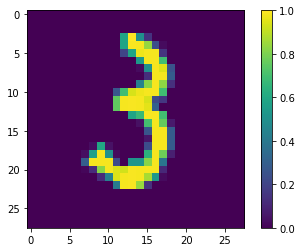

In [4]:
index = 1234
print("label = {}".format(train_labels[index]))
plt.imshow(train_data[index].reshape(28, 28))
plt.colorbar()
#plt.gca().grid(False)
plt.show()

## Set up dataset with `tf.data`

### input pipeline `tf.data.Dataset` and Transformation

In [5]:
def one_hot_label(image, label):
  label = tf.one_hot(label, depth=10)
  return image, label

In [6]:
tf.random.set_random_seed(219)
batch_size = 32
max_epochs = 10

# for train
N = len(train_data)
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<DatasetV1Adapter shapes: ((?, 784), (?, 10)), types: (tf.float32, tf.float32)>
<DatasetV1Adapter shapes: ((?, 784), (?, 10)), types: (tf.float32, tf.float32)>


## Create the model

* Use `tf.keras.layers`

In [7]:
model = tf.keras.models.Sequential()

In [8]:
# Adds a densely-connected layer with 64 units to the model:
#model.add(layers.Dense(64, activation='relu'))
# Add another:
#model.add(layers.Dense(64, activation='relu'))
# Add a softmax layer with 10 output units:
model.add(layers.Dense(10, activation='softmax'))

In [10]:
# without training, just inference a model in eager execution:
for images, labels in train_dataset.take(1):
  predictions = model(images[0:1])
  print("Predictions: ", predictions.numpy())

Predictions:  [[0.08369754 0.16445103 0.04734642 0.16805424 0.06879296 0.10811285
  0.12155081 0.11506331 0.07185962 0.0510713 ]]


In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


## Train a model

### Define loss and accuray functions

In [12]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
acc_object = tf.keras.metrics.CategoricalAccuracy()

### Define a optimizer

In [13]:
# use SGD optimizer
optimizer = tf.train.GradientDescentOptimizer(0.5)

# record accuracy for every epoch
mean_loss = tf.keras.metrics.Mean("loss")
mean_accuracy = tf.keras.metrics.Mean("accuracy")

# save loss and accuracy history for plot
loss_history = []
accuracy_history = [(0, 0.0)]

### Train a model

In [ ]:
print("start training!")
global_step = 0
num_batches_per_epoch = int(N / batch_size)

for epoch in range(max_epochs):
  
  for step, (images, labels) in enumerate(train_dataset):
    start_time = time.time()
    
    with tf.GradientTape() as tape:
      predictions = model(images, training=True)
      loss_value = loss_object(labels, predictions)
      acc_value = acc_object(labels, predictions)

    gradients = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    global_step += 1
    
    mean_loss(loss_value)
    mean_accuracy(acc_value)
    loss_history.append((global_step, mean_loss.result().numpy()))

    if global_step % 100 == 0:
      clear_output(wait=True)
      epochs = epoch + step / float(num_batches_per_epoch)
      duration = time.time() - start_time
      examples_per_sec = batch_size / float(duration)
      print("epochs: {:.2f}, step: {}, loss: {:.3g}, accuracy: {:.4g}% ({:.2f} examples/sec; {:.4f} sec/batch)".format(
          epochs, global_step, mean_loss.result().numpy(), mean_accuracy.result().numpy()*100, examples_per_sec, duration))
      
  # save mean accuracy for plot
  accuracy_history.append((global_step, mean_accuracy.result().numpy()))

  # clear the history
  mean_loss.reset_states()
  mean_accuracy.reset_states()

print("training done!")

### Plot the loss funtion

In [ ]:
plt.plot(*zip(*loss_history), label='loss')
plt.xlabel('Number of steps')
plt.ylabel('Loss value [cross entropy]')
plt.legend()
plt.show()

In [ ]:
plt.plot(*zip(*accuracy_history), 'bo', label='accuracy')
plt.xlabel('Number of steps')
plt.ylabel('Accuracy value')
plt.legend()
plt.show()

## Evaluate a model

### Test trained model

* Compare test accuracy for 1 epoch and 10 epochs

In [ ]:
for images, labels in test_dataset:
  predictions = model(images, training=False)
  acc_object(labels, predictions)
  
print("test accuracy: {:.4g}%".format(acc_object.result() * 100))

### Plot for test set

In [ ]:
np.random.seed(219)

In [ ]:
test_batch_size = 16
batch_index = np.random.choice(len(test_data), size=test_batch_size, replace=False)

batch_xs = test_data[batch_index]
batch_ys = test_labels[batch_index]
y_pred_ = model(batch_xs, training=False)

fig = plt.figure(figsize=(16, 10))
for i, (px, py) in enumerate(zip(batch_xs, y_pred_)):
  p = fig.add_subplot(4, 8, i+1)
  if np.argmax(py) == batch_ys[i]:
    p.set_title("y_pred: {}".format(np.argmax(py)), color='blue')
  else:
    p.set_title("y_pred: {}".format(np.argmax(py)), color='red')
  p.imshow(px.reshape(28, 28))
  p.axis('off')